In [60]:
import pandas as pd
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import IsolationForest
from src.utility.savefig import savefig

In [61]:
processed_data_dir = Path("data/processed")
interim_data_dir = Path("data/interim")

df = pd.read_csv(interim_data_dir / "02_data.csv")
print("Full preprocessed dataframe:", df.shape)
print(df.head())

X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_val   = pd.read_csv(processed_data_dir / "X_val.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")

y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze("columns")
y_val   = pd.read_csv(processed_data_dir / "y_val.csv").squeeze("columns")
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze("columns")

print("Train split:", X_train.shape, y_train.shape)
print("Validation split:", X_val.shape, y_val.shape)
print("Test split:", X_test.shape, y_test.shape)

Full preprocessed dataframe: (54170, 26)
              DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0  2019-01-01 00:00:00         6352        6527     1395    79           1383   
1  2019-01-01 01:00:00         6116        5701     1393    96           1112   
2  2019-01-01 02:00:00         5873        5676     1393   142           1030   
3  2019-01-01 03:00:00         5682        5603     1397   191            972   
4  2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  ...  demand_High  hour day_of_week  \
0         1896  1744      0       30  ...        False     0           1   
1         1429  1641      0       30  ...        False     1           1   
2         1465  1616      0       30  ...        False     2           1   
3         1455  1558      0       30  ...        False     3           1   
4         1454  1458      0       30  ...        False     4           1   

   month  hour_

Figure saved: outputs/figures/distribution_hours.png


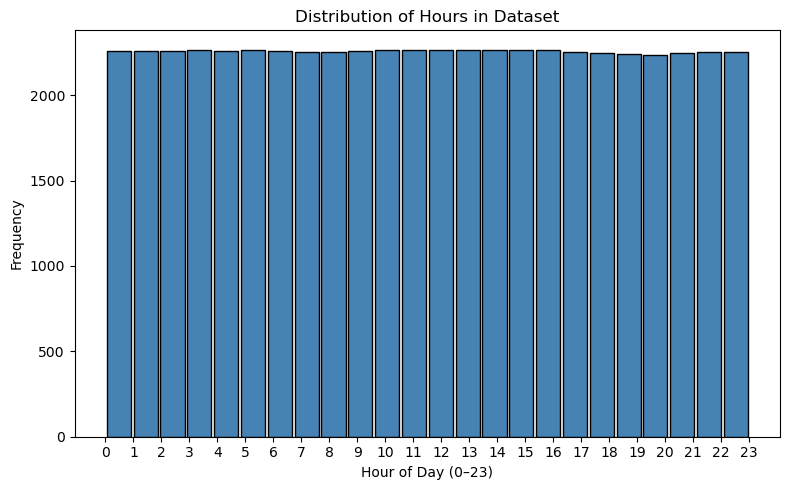

In [62]:
plt.figure(figsize=(8,5))
df["hour"].plot(kind="hist", bins=24, rwidth=0.9, color="steelblue", edgecolor="black")
plt.title("Distribution of Hours in Dataset")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Frequency")
plt.xticks(range(0,24))
savefig("distribution_hours")
plt.show()

Figure saved: outputs/figures/distribution_days.png


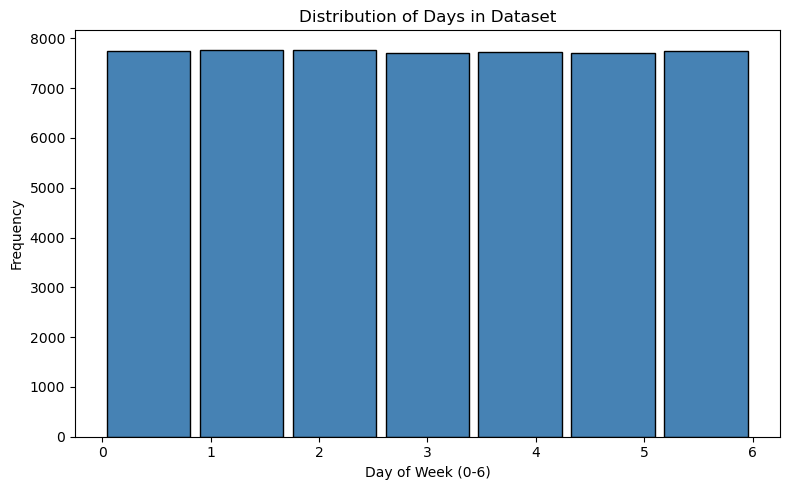

In [63]:
plt.figure(figsize=(8,5))
df["day_of_week"].plot(kind="hist", bins=7, rwidth=0.9, color="steelblue", edgecolor="black")
plt.title("Distribution of Days in Dataset")
plt.xlabel("Day of Week (0-6)")
plt.ylabel("Frequency")
plt.xticks(range(0,7))
savefig("distribution_days")
plt.show()

Figure saved: outputs/figures/distribution_months.png


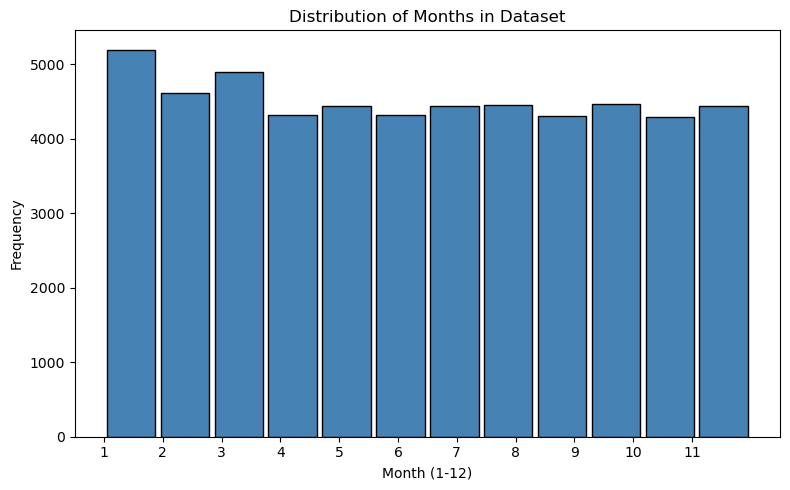

In [64]:
plt.figure(figsize=(8,5))
df["month"].plot(kind="hist", bins=12, rwidth=0.9, color="steelblue", edgecolor="black")
plt.title("Distribution of Months in Dataset")
plt.xlabel("Month (1-12)")
plt.ylabel("Frequency")
plt.xticks(range(1,12))
savefig("distribution_months")
plt.show()

Figure saved: outputs/figures/distribution_cons.png


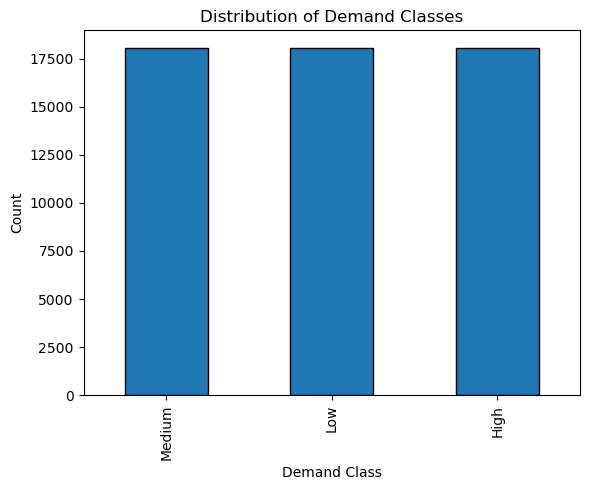

In [65]:
plt.figure(figsize=(6,5))
df["demand_class"].value_counts().plot(kind="bar", edgecolor="black")
plt.title("Distribution of Demand Classes")
plt.xlabel("Demand Class")
plt.ylabel("Count")
savefig("distribution_cons")
plt.show()

## Variable Distribution Analysis (Histograms)

- **Consumption (capped):**
  - Distribution is right-skewed but smoother after capping outliers.
  - Most demand values cluster in the mid-range, with clear separation of Low/Medium/High classes.
  - ⚠️ Potential issue: class cutoffs are sensitive to seasonal peaks, which may shift over time.

- **Hour of Day:**
  - Histogram is uniform across all 24 hours, confirming full daily coverage.
  - ⚠️ Potential issue: model may learn cyclical patterns well, but if future data has missing hours (reporting gaps), performance could degrade.

- **Day of Week:**
  - All 7 days are evenly represented in the dataset.
  - ⚠️ Potential issue: industrial demand differences between weekdays and weekends should be validated against domain knowledge.

- **Month:**
  - All 12 months present, with higher average consumption in colder months (winter).
  - ⚠️ Potential issue: seasonal bias means “High” demand may concentrate heavily in winter, which could influence class balance when applied to future unseen years.

In [66]:
target = "demand_class_encoded"
# Choose categorical features (raw discrete categories, not sin/cos)
categorical_features = ["hour", "day_of_week", "month"]
chi2_results = []
for col in categorical_features:
    # Build contingency table
    contingency_table = pd.crosstab(df[col], df[target])
    # Run chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append({
        "Feature": col,
        "Chi2": chi2,
        "p-value": p,
        "Degrees of Freedom": dof,
        "Significant (p<0.05)": p < 0.05
    })
# Convert to DataFrame for easy viewing
chi2_df = pd.DataFrame(chi2_results)
print(chi2_df)

       Feature          Chi2  p-value  Degrees of Freedom  \
0         hour  21982.596451      0.0                  46   
1  day_of_week   6638.891726      0.0                  12   
2        month   6237.381912      0.0                  22   

   Significant (p<0.05)  
0                  True  
1                  True  
2                  True  


## Chi-Square Analysis of Categorical Features

We applied a Chi-Square test of independence to evaluate whether key categorical time features 
(`hour`, `day_of_week`, `month`) are associated with the target variable (`demand_class_encoded`).

### Results
| Feature       | Chi2       | p-value | DoF | Significant |
|---------------|------------|---------|-----|-------------|
| **hour**      | 21,982.60  | 0.0     | 46  | ✅ Yes |
| **day_of_week** | 6,638.89   | 0.0     | 12  | ✅ Yes |
| **month**     | 6,237.38   | 0.0     | 22  | ✅ Yes |

### Interpretation
- **Hour of Day** shows the strongest association with demand class.  
  This confirms clear **daily cycles** in electricity demand, with predictable peaks and troughs.
- **Day of Week** also has a significant relationship.  
  Demand is systematically different on weekdays vs weekends, reflecting industrial and commercial usage patterns.
- **Month** is strongly associated with demand class, capturing **seasonal variation**.  
  High demand is concentrated in colder months, while lower demand aligns with summer.

### Key Insight
All three features have **very low p-values (<0.05)**, indicating strong evidence against independence.  
This means **demand class is not randomly distributed across time categories**, but instead strongly influenced by **daily, weekly, and seasonal cycles**.

### Caveat
With a large dataset (~54,000 rows), even small deviations can yield very high Chi2 values.  
While all associations are statistically significant, further analysis using **effect size (Cramer’s V)** and **visualizations** is necessary to understand the **practical strength** of these relationships.

Figure saved: outputs/figures/correlation_heatmap.png


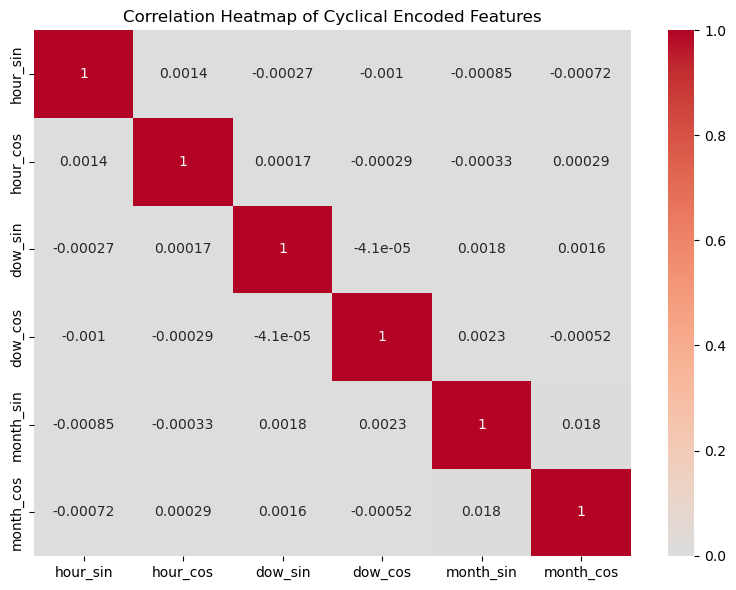

In [67]:
# Select only numeric features (excluding target for now)
numeric_features = ["hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos"]

plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Cyclical Encoded Features")
savefig("correlation_heatmap")
plt.show()

The correlation heatmap reveals expected strong negative correlations within each cyclical pair (e.g., hour_sin vs hour_cos), since sine and cosine together encode the same cycle. No unexpected correlations appear across different cycles (hour, day, month), which suggests they provide independent temporal signals. There is no evidence of feature redundancy beyond the paired encodings. This supports the decision to keep both sine and cosine terms to preserve full cyclical information. For early dimensionality reduction, PCA could compress each pair into one component, though interpretability may suffer. Overall, the features appear well-structured without spurious correlations.

     Feature  MI Score
0   hour_sin  0.087821
1   hour_cos  0.080681
2    dow_sin  0.069554
5  month_cos  0.030066
3    dow_cos  0.017164
4  month_sin  0.016809
Figure saved: outputs/figures/feature_importance.png


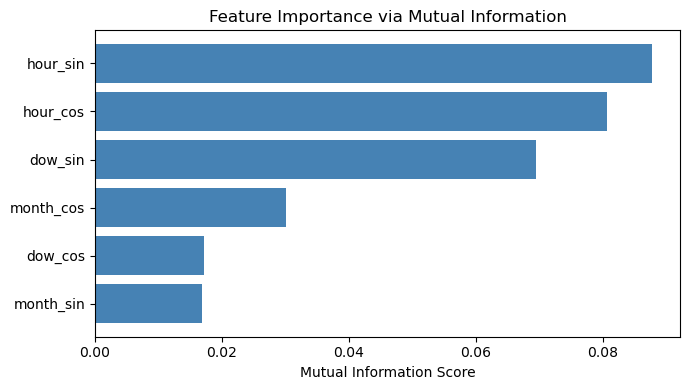

In [68]:
# Compute mutual information scores
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=42)

# Put into DataFrame
mi_df = pd.DataFrame({"Feature": X_train.columns, "MI Score": mi_scores}).sort_values("MI Score", ascending=False)
print(mi_df)

# Plot
plt.figure(figsize=(7,4))
plt.barh(mi_df["Feature"], mi_df["MI Score"], color="steelblue")
plt.xlabel("Mutual Information Score")
plt.title("Feature Importance via Mutual Information")
plt.gca().invert_yaxis()
savefig("feature_importance")
plt.show()

## Mutual Information Feature Importance

We used `mutual_info_classif` to estimate how much information each feature provides about the target (`demand_class_encoded`).

### Results
| Feature     | MI Score |
|-------------|----------|
| hour_sin    | 0.0878   |
| hour_cos    | 0.0807   |
| dow_sin     | 0.0696   |
| month_cos   | 0.0301   |
| dow_cos     | 0.0172   |
| month_sin   | 0.0168   |

### Interpretation
- **Hour features (`hour_sin`, `hour_cos`)** have the highest MI scores, confirming that **time of day** is the strongest predictor of demand tier. This aligns with known daily demand cycles.  
- **Day of week (`dow_sin`, `dow_cos`)** also provides useful signal, though weaker. This suggests systematic differences between weekdays and weekends.  
- **Month features (`month_sin`, `month_cos`)** show the lowest scores. While seasonality affects demand, it appears less informative compared to daily or weekly cycles.  
- The asymmetry between sine and cosine encodings indicates redundancy, but keeping both preserves full cyclical representation.  

### Key Insight
Demand classification is driven primarily by **daily cycles**, moderately by **weekly patterns**, and only weakly by **seasonality**. Early feature selection could prioritize **hour and day encodings** while testing whether month encodings add enough value to justify inclusion.

In [69]:
# Use capped consumption as input
X_cons = df[["Consumption_capped"]]

# Train Isolation Forest
iso_cons = IsolationForest(contamination=0.01, random_state=42)
df["cons_anomaly_score"] = iso_cons.fit_predict(X_cons)
df["cons_anomaly_value"] = iso_cons.decision_function(X_cons)

# Extract anomalies
cons_anomalies = df[df["cons_anomaly_score"] == -1]
print("Consumption anomalies detected:", cons_anomalies.shape[0])
cons_anomalies[["DateTime", "Consumption_capped", "demand_class", "cons_anomaly_value"]].head(10)

Consumption anomalies detected: 538


,DateTime,Consumption_capped,demand_class,cons_anomaly_value
176,2019-01-08 08:00:00,9170.0000,High,-0.026633
177,2019-01-08 09:00:00,9322.5775,High,-0.037024
178,2019-01-08 10:00:00,9322.5775,High,-0.037024
179,2019-01-08 11:00:00,9322.5775,High,-0.037024
180,2019-01-08 12:00:00,9131.0000,High,-0.022225
181,2019-01-08 13:00:00,9101.0000,High,-0.017832
185,2019-01-08 17:00:00,9322.5775,High,-0.037024
186,2019-01-08 18:00:00,9322.5775,High,-0.037024
187,2019-01-08 19:00:00,9318.0000,High,-0.037024
188,2019-01-08 20:00:00,9123.0000,High,-0.022225


Figure saved: outputs/figures/anomaly_over_time.png


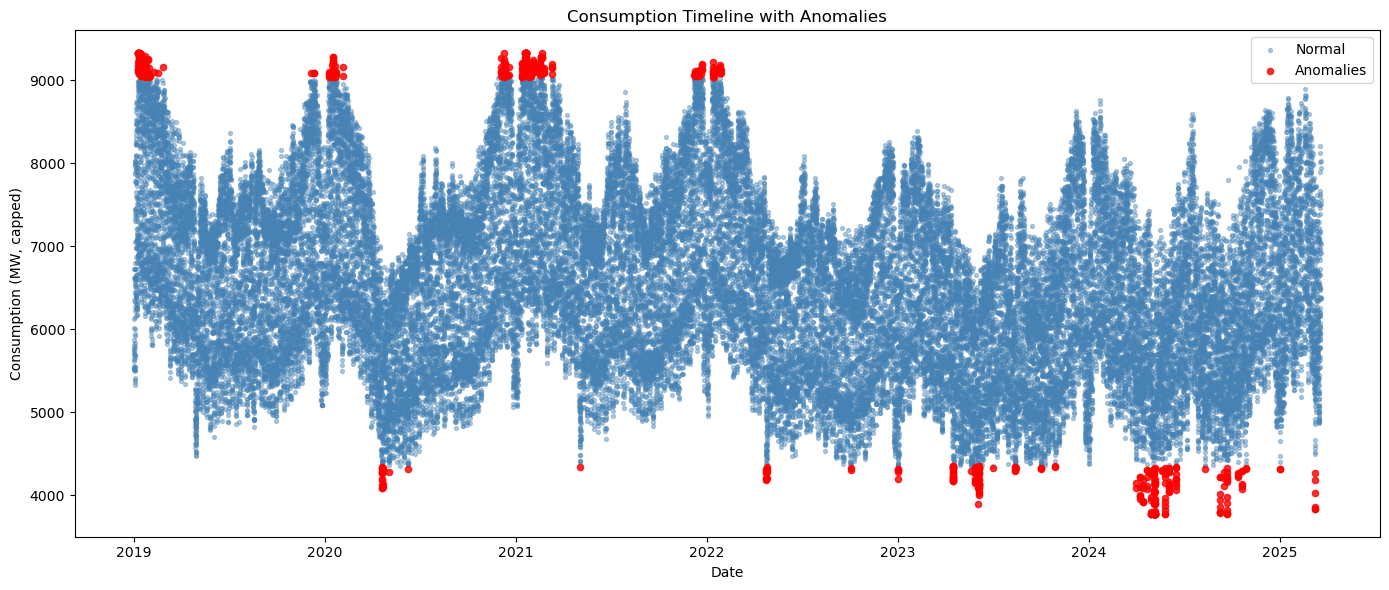

In [70]:
df["DateTime"] = pd.to_datetime(df["DateTime"])

plt.figure(figsize=(14,6))

# Plot all normal records
normal = df[df["cons_anomaly_score"] == 1]
plt.scatter(
    normal["DateTime"], normal["Consumption_capped"],
    color="steelblue", alpha=0.4, s=8, label="Normal"
)

# Plot anomalies
anomalies = df[df["cons_anomaly_score"] == -1]
plt.scatter(
    anomalies["DateTime"], anomalies["Consumption_capped"],
    color="red", alpha=0.8, s=20, label="Anomalies"
)

plt.title("Consumption Timeline with Anomalies")
plt.xlabel("Date")
plt.ylabel("Consumption (MW, capped)")
plt.legend()
savefig("anomaly_over_time")
plt.show()

## Anomaly Detection Results – Consumption Timeline

### Key Observations
- **Seasonal Peaks:**  
  Many anomalies occur during winter demand spikes (2019–2022).  
  These likely represent **rare but valid high-demand events** such as cold spells or holidays.

- **Recent Low Anomalies:**  
  From 2023 onward, anomalies appear at the **low end of consumption** (< 4500 MW).  
  Unlike the earlier peaks, these are more frequent and scattered, suggesting either  
  **structural demand changes** (reduced baseline) possibly related to lifted COVID restrictions.

- **Clustering:**  
  Anomalies group in specific time bands — peaks in earlier years and troughs in later years.  
  This points to a **non-stationary dataset**, where the distribution of demand evolves over time.

### Potential Issues
- **True errors:** Isolated dips inconsistent with surrounding context.  
- **Rare valid events:** Seasonal spikes that should be kept for model training.  
- **Structural shifts:** Sustained low anomalies may require rethinking tier definitions.

### Next Step
Analyze anomalies by **year and month** to confirm whether recent low anomalies  
reflect genuine demand changes or data inconsistencies.

month    1     2    3     4     5     6    7    8     9     10    12
year                                                                
2019   75.0   3.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   3.0
2020   32.0   2.0  0.0  18.0   1.0   1.0  0.0  0.0   0.0   0.0  32.0
2021   61.0  37.0  4.0   0.0   1.0   0.0  0.0  0.0   0.0   0.0  14.0
2022   19.0   0.0  0.0  10.0   0.0   0.0  0.0  0.0   0.0   2.0   0.0
2023    5.0   0.0  0.0  19.0  10.0  28.0  1.0  5.0   0.0   5.0   0.0
2024    0.0   0.0  2.0  27.0  59.0  19.0  0.0  1.0  23.0  11.0   0.0
2025    2.0   0.0  6.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0
Figure saved: outputs/figures/anomaly_frequency.png


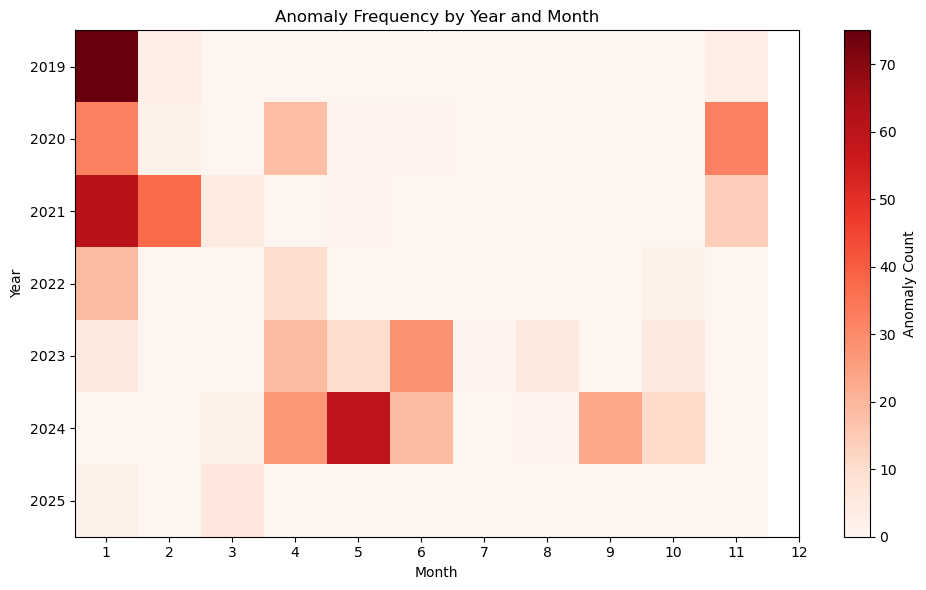

In [71]:
# Ensure datetime
df["DateTime"] = pd.to_datetime(df["DateTime"])

# Extract anomalies
anomalies = df[df["cons_anomaly_score"] == -1].copy()
anomalies["year"] = anomalies["DateTime"].dt.year
anomalies["month"] = anomalies["DateTime"].dt.month

# Group counts
anomaly_counts = anomalies.groupby(["year", "month"]).size().reset_index(name="count")

# Pivot for heatmap view
pivot_table = anomaly_counts.pivot(index="year", columns="month", values="count").fillna(0)

print(pivot_table)

# Plot as heatmap
plt.figure(figsize=(10,6))
plt.title("Anomaly Frequency by Year and Month")
plt.xlabel("Month")
plt.ylabel("Year")
plt.imshow(pivot_table, aspect="auto", cmap="Reds")
plt.colorbar(label="Anomaly Count")
plt.xticks(range(12), range(1,13))
plt.yticks(range(len(pivot_table.index)), pivot_table.index)
savefig("anomaly_frequency")
plt.show()